In [63]:
import numpy as np 
import cv2
import glob
import os
import matplotlib.pyplot as plt
import string
import joblib
#from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC

print(os.listdir("../data"))
dim = 100

['Kaggle_Fruits360', 'census', 'archive', 'AI2223Jaar3_Groep1', 'archive.zip', 'Kaggle_Fruits360.zip', 'empty.data', 'titantic']


In [35]:
def getYourFruits(fruits, data_type, print_n=False, k_fold=False):
    images = []
    labels = []
    val = ['Training', 'Test']
    if not k_fold:
        path = "../data/Kaggle_Fruits360/fruits-360_dataset/fruits-360/" + data_type + "/"
        for i,f in enumerate(fruits):
            p = path + f
            j=0
            for image_path in glob.glob(os.path.join(p, "*.jpg")):
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.resize(image, (dim, dim))
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                images.append(image)
                labels.append(i)
                j+=1
            if(print_n):
                print("There are " , j , " " , data_type.upper(), " images of " , fruits[i].upper())
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    else:
        for v in val:
            path = "../data/Kaggle_Fruits360/fruits-360_dataset/fruits-360/" + v + "/"
            for i,f in enumerate(fruits):
                p = path + f
                j=0
                for image_path in glob.glob(os.path.join(p, "*.jpg")):
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                    image = cv2.resize(image, (dim, dim))
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    images.append(image)
                    labels.append(i)
                    j+=1
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    
def getAllFruits():
    fruits = []
    for fruit_path in glob.glob("../data/Kaggle_Fruits360/fruits-360_dataset/fruits-360/Training/*"):
        fruit = fruit_path.split("/")[-1]
        fruits.append(fruit)
    return fruits
    

In [36]:
#Choose your Fruits
fruits = ['Pineapple' , 'Cocos'] #Binary classification

#Get Images and Labels 
X_t, y_train =  getYourFruits(fruits, 'Training', print_n=True, k_fold=False)
X_test, y_test = getYourFruits(fruits, 'Test', print_n=True, k_fold=False)

#Get data for k-fold
X,y = getYourFruits(fruits, '', print_n=True, k_fold=True)

#Scale Data Images
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X_t])
X_test = scaler.fit_transform([i.flatten() for i in X_test])
X = scaler.fit_transform([i.flatten() for i in X])

There are  490   TRAINING  images of  PINEAPPLE
There are  490   TRAINING  images of  COCOS
There are  166   TEST  images of  PINEAPPLE
There are  166   TEST  images of  COCOS


In [37]:
def plot_image_grid(images, nb_rows, nb_cols, figsize=(15, 15)):
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n])
            n += 1        

Pineapple


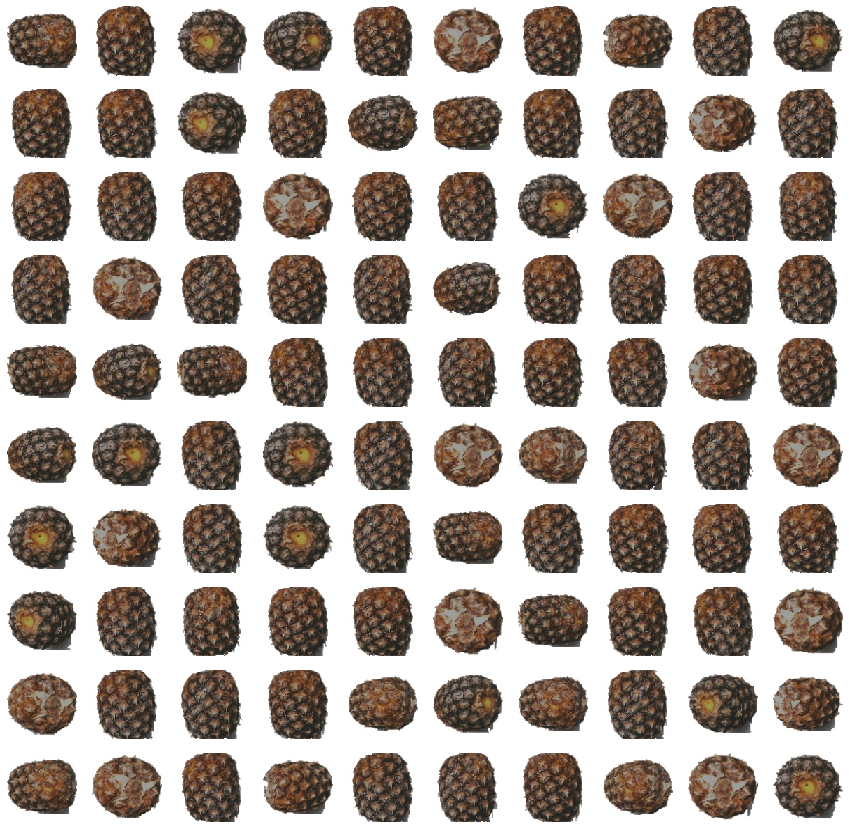

In [38]:
print(fruits[y_train[0]])
plot_image_grid(X_t[0:100], 10, 10)

In [39]:
def getClassNumber(y):
    v =[]
    i=0
    count = 0
    for index in y:
        if(index == i):
            count +=1
        else:
            v.append(count)
            count = 1
            i +=1
    v.append(count)        
    return v

def plotPrincipalComponents(X, dim):
    v = getClassNumber(y_train)
    colors = 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple'
    markers = ['o', 'x' , 'v', 'd']
    tot = len(X)
    start = 0 
    if(dim == 2):
        for i,index in enumerate(v):
            end = start + index
            plt.scatter(X[start:end,0],X[start:end,1] , color=colors[i%len(colors)], marker=markers[i%len(markers)], label = fruits[i])
            start = end
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    
    if(dim == 3):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for i,index in enumerate(v):
            end = start + index
            ax.scatter(X[start:end,0], X[start:end,1], X[start:end,2], color=colors[i%len(colors)], marker=markers[i%len(markers)], label = fruits[i])
            start = end
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')


    plt.legend(loc='lower left')
    plt.xticks()
    plt.yticks()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=fruits, yticklabels=fruits,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm,ax

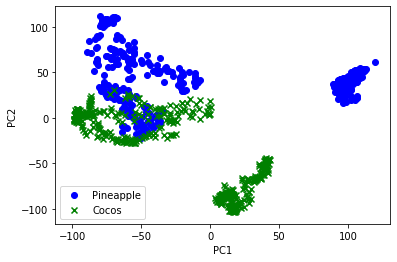

In [40]:
pca = PCA(n_components=2)
dataIn2D = pca.fit_transform(X_train)
plotPrincipalComponents(dataIn2D, 2)

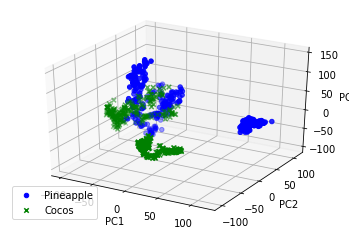

In [41]:
pca = PCA(n_components=3)
dataIn3D = pca.fit_transform(X_train)
plotPrincipalComponents(dataIn3D, 3)

In [42]:
def showPCA(image,X2, X10, X50):
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(1,4,1)
    ax1.axis('off')
    ax1.set_title('Original image')
    plt.imshow(image)
    ax1 = fig.add_subplot(1,4,2)
    ax1.axis('off') 
    ax1.set_title('50 PC')
    plt.imshow(X50)
    ax1 = fig.add_subplot(1,4,3)
    ax1.axis('off') 
    ax1.set_title('10 PC')
    plt.imshow(X10)
    ax2 = fig.add_subplot(1,4,4)
    ax2.axis('off') 
    ax2.set_title('2 PC')
    plt.imshow(X2)
    plt.show()

def computePCA(n, im_scaled, image_id):
    pca = PCA(n)
    principalComponents = pca.fit_transform(im_scaled)
    im_reduced = pca.inverse_transform(principalComponents)
    newImage = scaler.inverse_transform(im_reduced[image_id])
    return newImage

def showVariance(X_train):
    #Compute manually the principal components
    cov_matr=np.dot(X_train, X_train.T)
    eigval,eigvect=np.linalg.eig(cov_matr)

    index=np.argsort(eigval)[::-1] #take in order the index of ordered vector (ascending order)

    #eigvect[:,i] is associated to eigval[i] so 
    eigvect=eigvect[:,index]
    eigval=eigval[index]

    n_PC=[]
    var_explained=[]
    var_temp=[]
    var_tmp=0
    for i in range(10):
        var_tmp=var_tmp+eigval[i]
        n_PC.append(i)
        var_temp.append(eigval[i]/(eigval.sum())*100)
        var_explained.append(var_tmp/(eigval.sum())*100)

    fig, ax = plt.subplots(figsize=(8,8))

    ind = np.arange(10)    
    width = 0.35         # the width of the bars
    p1 = ax.bar(ind, var_temp, width, color='b')
    p2 = ax.bar(ind + width, var_explained, width, color='r')

    ax.legend((p1[0], p2[0]), ('Individual explained variance', 'Cumulative explained variance'))

    ax.set_title('Variance explained using PCs')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('1', '2', '3', '4', '5', '6', '7', '8', '9', '10'))

    plt.xlabel('Number of PC')
    plt.ylabel('Variance exaplained in %')

    ax.autoscale_view()

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


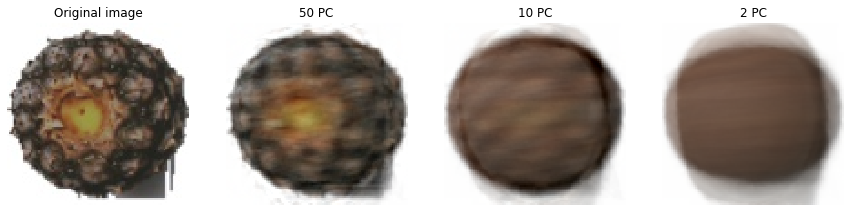

In [43]:
image_id = 2
image = X_t[image_id]

#Compute PCA
X_2 = computePCA(2, X_train,image_id)
X_10 = computePCA(10, X_train,image_id)
X_50 = computePCA(50, X_train,image_id)

#Reshape in order to plot images
X2 = np.reshape(X_2, (dim,dim,3)).astype(int)
X10 = np.reshape(X_10, (dim,dim,3)).astype(int)
X50 = np.reshape(X_50, (dim,dim,3)).astype(int)

#Plot
showPCA(image, X2, X10, X50)

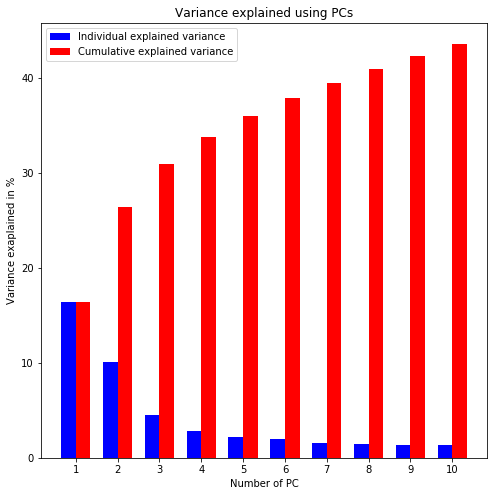

In [44]:
showVariance(X_train)

## Linear SVM

Accuracy with SVM: 97.59%


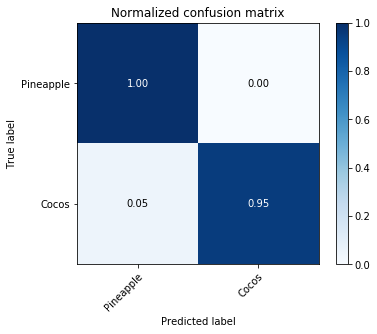

In [46]:
svm = SVC(gamma='auto', kernel='linear', probability=True)
svm.fit(X_train, y_train) 
y_pred = svm.predict(X_test)

#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with SVM: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred,classes=y_train, normalize=True, title='Normalized confusion matrix')
plt.ylim([1.5, -.5])
plt.show()

# calculate the FPR and TPR for all thresholds of the classification
probs = svm.predict_proba(X_test)
probs = probs[:, 1]
svm_fpr, svm_tpr, thresholds = metrics.roc_curve(y_test, probs)
svm_auc = metrics.roc_auc_score(y_test, probs)

SVM + K-FOLD

In [47]:
pred_kfold = cross_val_score(svm, X, y, cv=5) 
print("Accuracy with SVM and K-FOLD CROSS VALIDATION: %0.2f (+/- %0.2f)" % (pred_kfold.mean(), pred_kfold.std() * 2))

Accuracy with SVM and K-FOLD CROSS VALIDATION: 1.00 (+/- 0.00)


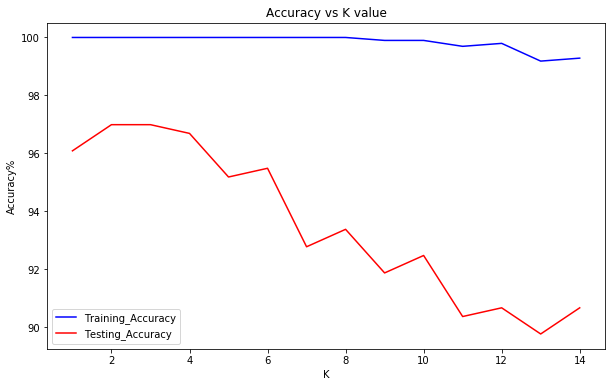

In [48]:
#CHANGING VALUES OF N
accuracy_train = []
accuracy_test = []

for i in range(1,15):   #check all possible values for 1 to 15
    k_nn = KNeighborsClassifier(n_neighbors=i)
    k_nn.fit(X_train,y_train)
    pred_i = k_nn.predict(X_test)
    accuracy_train.append(k_nn.score(X_train,y_train)*100)
    accuracy_test.append(k_nn.score(X_test,y_test)*100)
    
accuracy_train_array=np.asarray(accuracy_train)
accuracy_test_array=np.asarray(accuracy_test)
    
plt.figure(figsize=(10,6))
plt.plot(range(1,15),accuracy_train_array, label='Training_Accuracy', color='blue')
plt.plot(range(1,15),accuracy_test_array, label='Testing_Accuracy', color='red')
plt.legend()
plt.title('Accuracy vs K value')
plt.xlabel('K')
plt.ylabel('Accuracy%')

plt.show()


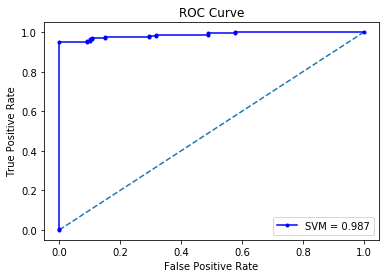

In [54]:
#ROC CURVE
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(svm_fpr, svm_tpr, 'b', marker='.', label = 'SVM = %0.3f' % svm_auc )
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## MULTI-CLASS CLASSIFICATION

In [57]:
fruits = ['Orange', 'Banana' , 'Apple', 'Kiwi' , 'Grape', 'Plum', 'Pear', 'Nectarine', 'Mandarine']
#fruits = getAllFruits() #Be sure to have enough free memory

#Get Images and Labels
X, y =  getYourFruits(fruits, 'Training')
X_test, y_test = getYourFruits(fruits, 'Test')

#Scale Data Images
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X])
X_test = scaler.fit_transform([i.flatten() for i in X_test])

In [58]:
#SVM
model = SVC(gamma='auto', kernel='linear')
model.fit(X_train, y) 
y_pred = model.predict(X_test)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with SVM: {0:.2f}%".format(precision))

Accuracy with SVM: 100.00%


In [64]:
joblib.dump(model, 'svm-fruitmodel-liam-1.sav')

['svm-fruitmodel-liam-1.sav']